# Object-oriented FISSA interface

This notebook contains a step-by-step example of how to use the object-oriented (class-based) interface to the [FISSA](https://github.com/rochefort-lab/fissa) toolbox.

For more details about the methodology behind FISSA, please see our paper:
> S. W. Keemink, S. C. Lowe, J. M. P. Pakan, E. Dylda, M. C. W. van Rossum, and N. L. Rochefort. FISSA: A neuropil decontamination toolbox for calcium imaging signals, *Scientific Reports*, **8**(1):3493, 2018. doi: [10.1038/s41598-018-21640-2](https://www.doi.org/10.1038/s41598-018-21640-2).

See [basic_usage.py](https://github.com/rochefort-lab/fissa/blob/master/examples/basic_usage.py) (or [basic_usage_windows.py](https://github.com/rochefort-lab/fissa/blob/master/examples/basic_usage_windows.py) for Windows users) for a short example script outside of a notebook interface.

### Import packages

In [1]:
# Import the FISSA toolbox
import fissa

In [2]:
# For plotting our results, import numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Fetch the colormap object for Cynthia Brewer's Paired color scheme
cmap = plt.get_cmap("Paired")

## Defining an experiment

To run a separation step with fissa, you need create a `fissa.Experiment` object, which will hold your extraction parameters and results.

The inputs to the `fissa.Experiment` instance are the:
- experiment images
- the regions of interest (ROIs) to extract
Define your inputs. All that's necessary to define are the image data and ROIs. 

Images can be defined as a folder with tiff stacks:
```python
images = "folder"
```
Where each tiff stack in the folder is a trial with several frames.

Or the data can also be given as a list of arrays if not stored as tiffs:
```python
images = [array1, array2, array3, ...]
```

For ROIs either a set of ROIs across all images should be defined, or a set of ROIs per image. 

If the ROIs were defined using ImageJ use ImageJ's export function to save them in a zip. Then, indicate the locations as a list:
```python
rois = "rois.zip"  # for a single set of rois across images
rois = ["rois1.zip", "rois2.zip", ...]  # for a roiset for each image
```
Defining a different roiset per image can be useful if you need to adjust for motion drift for example.

Then, we can define our experiment:

In [4]:
# Define the folder where FISSA's outputs will be cached, so they can be
# quickly reloaded in the future without having to recompute them.
#
# This argument is optional; if it is not provided, FISSA will not save its
# results for later use.
#
# Note: you *must* use a different folder for each experiment,
# otherwise FISSA will load the in the folder provided instead
# of computing results for the new experiment.

output_folder = "fissa-example"

In [5]:
# Define image and ROI locations
images_location = "exampleData/20150529"
rois_location = "exampleData/20150429.zip"

experiment = fissa.Experiment(images_location, rois_location, output_folder)

Previously analyzed experiments in output_folder will be loaded, if they exist, and the next step could be skipped.

### Extracting traces and separating them
Next, we need to extract the traces and separate them:

In [6]:
experiment.separate()

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.842 seconds.
Saving extracted traces to fissa-example/prepared.npz


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.652 seconds
Saving results to fissa-example/separated.npz


If you want to redo preparation and/or separation you can set:
```
experiment.separate(redo_prep=True, redo_sep=True)
```
(If you redo prepartion this will also redo the separation, to make sure these always match up).

## Accessing results

After running ```experiment.separate()``` the results are stored as follows.

### Mean image

You can get the temporal-mean image for a trial with `experiment.means`, which we plot below.

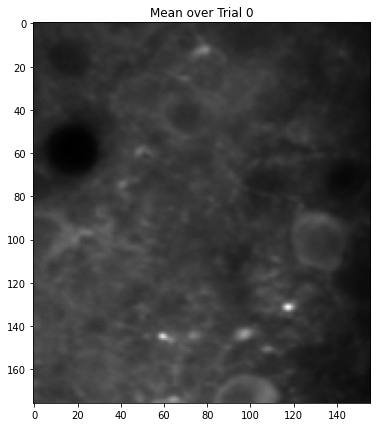

In [7]:
trial = 0
# Plot the mean image for one of the trials
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")
plt.title("Mean over Trial {}".format(trial))
plt.show()

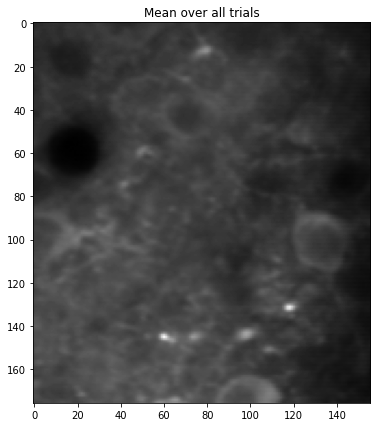

In [8]:
# Plot the mean image over all the trials
plt.figure(figsize=(7, 7))
plt.imshow(np.mean(experiment.means, axis=0), cmap="gray")
plt.title("Mean over all trials")
plt.show()

### ROI outlines

The ROI outlines, as well as the extra neuropil regions, can be found as in ```experiment.roi_polys``` as follows. For cell number ```c``` and tiff number `t`, the set of ROIs for that cell and tiff is at
```python
experiment.roi_polys[c][t][0][0]  # basic ROI
experiment.roi_polys[c][t][n][0]  # n = 1, 2, 3, ... the neuropil regions
```
Sometimes ROIs cannot be expressed as a single polygon (e.g. a ring-ROI), in those cases several polygons are used to describe it as:
```python
experiment.roi_polys[c][t][n][i]  # i iterates over the different polygons
```

As an example, plotting the first region of interest plus its surrounding neuropil subregions, overlaid on top of the mean image for one trial.

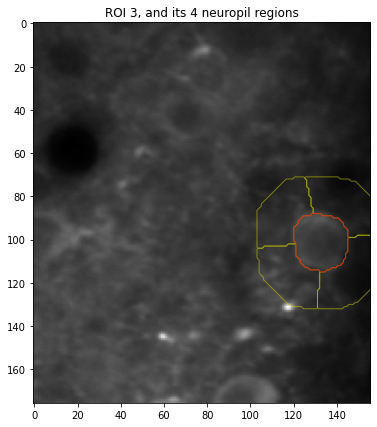

In [9]:
# Plot one ROI along with its neuropil regions

# Select which ROI and trial to plot
trial = 0
roi = 3

# Plot the mean image for the trial
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")
# Get axes limits
XLIM = plt.xlim()
YLIM = plt.ylim()

# Check the number of neuropil
n_npil = len(experiment.roi_polys[roi, trial]) - 1

# Plot all the neuropil regions in yellow
for i_npil in range(1, n_npil + 1):
    for contour in experiment.roi_polys[roi, trial][i_npil]:
        plt.fill(
            contour[:, 1],
            contour[:, 0],
            facecolor="none",
            edgecolor="y",
            alpha=0.6,
        )

# Plot the ROI outline in red
for contour in experiment.roi_polys[roi, trial][0]:
    plt.fill(
        contour[:, 1],
        contour[:, 0],
        facecolor="none",
        edgecolor="r",
        alpha=0.6,
    )

# Reset axes limits
plt.xlim(XLIM)
plt.ylim(YLIM)

plt.title("ROI {}, and its {} neuropil regions".format(roi, experiment.nRegions))
plt.show()

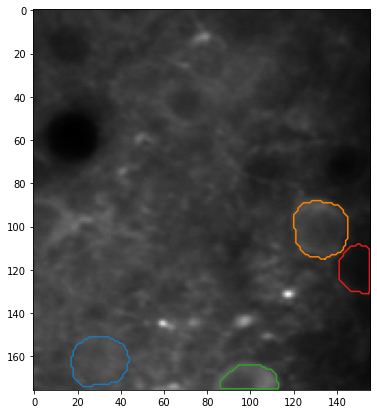

In [10]:
# Plot all cell ROI locations

# Select which trial (TIFF index) to plot
trial = 0

# Plot the mean image for the trial
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")

# Plot each of the cell ROIs
for i_roi in range(len(experiment.roi_polys)):
    # Plot border around ROI
    for contour in experiment.roi_polys[i_roi, trial][0]:
        plt.plot(
            contour[:, 1],
            contour[:, 0],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )

plt.show()

### FISSA extracted traces

The final extracted traces can be found in ```experiment.result``` as follows. For cell number ```c``` and tiff number `t`, the final extracted trace is given by:
```python
experiment.result[c][t][0, :]
```

In `experiment.result` one can find the signals present in the cell ROI, ordered by how strongly they are present (relative to the surrounding regions). `experiment.result[c][t][0, :]` gives the most strongly present signal, and is considered the cell's "true" signal. `[i, :]` for `i=1,2,3,...` gives the other signals which are present in the ROI, but driven by other cells or neuropil.

### Before decontamination

The raw extracted signals can be found in `experiment.raw` in the same way. Now in  `experiment.raw[c][t][i,:]`, `i` indicates the region number, with `i=0` being the cell, and `i=1,2,3,...` indicating the surrounding regions.

As an example, plotting the raw and extracted signals for the second trial for the third cell:

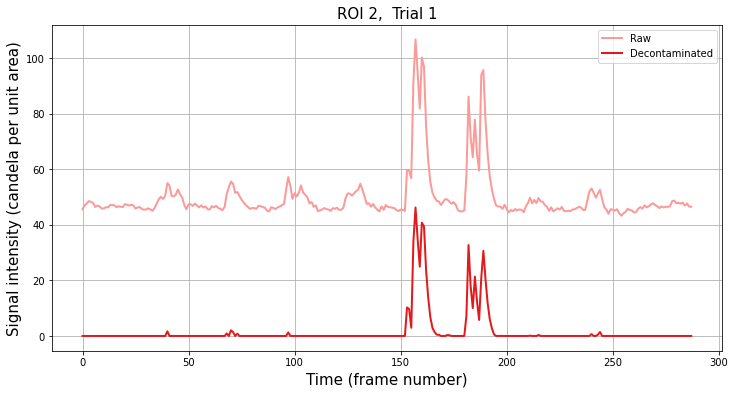

In [11]:
# Plot sample trace

# Select the ROI and trial to plot
roi = 2
trial = 1

# Create the figure
plt.figure(figsize=(12, 6))

plt.plot(
    experiment.raw[roi, trial][0, :], lw=2, label="Raw", color=cmap((roi * 2) % cmap.N)
)
plt.plot(
    experiment.result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=cmap((roi * 2 + 1) % cmap.N),
)

plt.title("ROI {},  Trial {}".format(roi, trial), fontsize=15)
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.grid()
plt.legend()
plt.show()

We can similarly plot raw and decontaminated traces for every ROI and every trial.

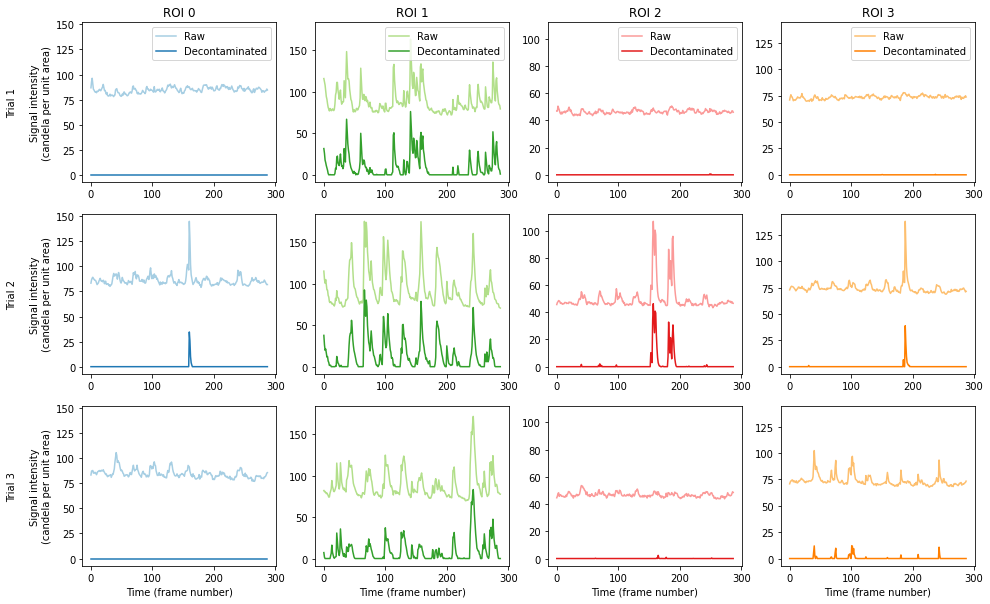

In [12]:
# Plot all ROIs and trials

# Get the number of ROIs and trials
n_roi = experiment.result.shape[0]
n_trial = experiment.result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max_raw = [
    np.max([np.max(experiment.raw[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max([np.max(experiment.result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        plt.plot(
            experiment.raw[i_roi][i_trial][0, :],
            label="Raw",
            color=cmap((i_roi * 2) % cmap.N),
        )
        plt.plot(
            experiment.result[i_roi][i_trial][0, :],
            label="Decontaminated",
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\nSignal intensity\n(candela per unit area)".format(
                    i_trial + 1
                )
            )
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
            plt.legend()
        if i_trial == n_trial - 1:
            plt.xlabel("Time (frame number)")

plt.show()

The figure above shows the raw signal from the annotated ROI location (pale), and the result after decontaminating the signal with FISSA (dark).
The hues match the ROI locations drawn above.
Each column shows the results from one of the ROI, and each row shows the results from one of the three trials.

### Comparing ROI signal to neuripil region signals
It can be very instructive to compare the signal in the central ROI with the surrounding neuropil regions. These can be found for cell `c` and trial `t` in `experiment.raw[c][t][i,:]`, with `i=0` being the cell, and `i=1,2,3,...` indicating the surrounding regions.

Below we compare directly the raw ROI trace, the decontaminated trace, and the surrounding neuropil region traces.

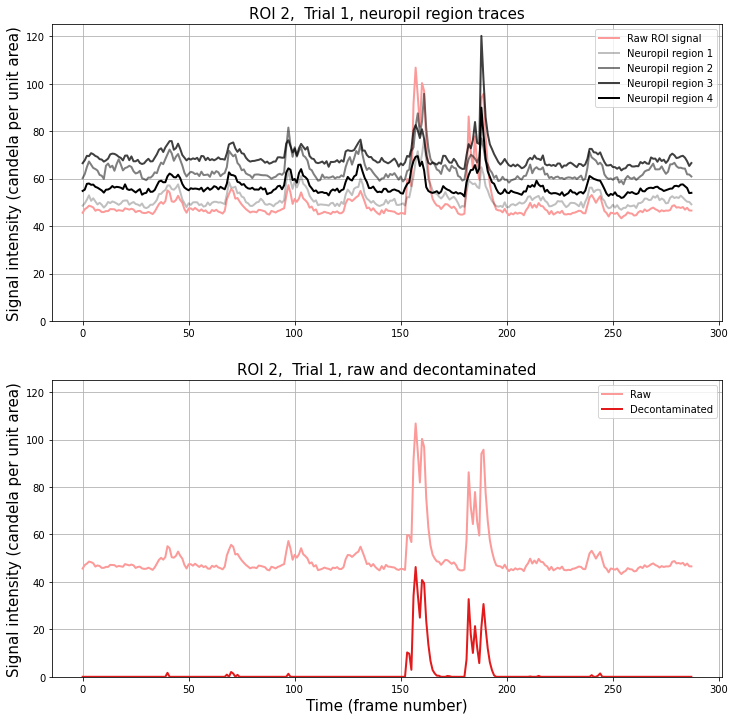

In [13]:
# get the total number of regions
nRegions = experiment.nRegions

# Select the ROI and trial to plot
roi = 2
trial = 1

# Create the figure
plt.figure(figsize=(12, 12))

# Plot extracted traces for each neuropil subregion
plt.subplot(2, 1, 1)
# Plot trace of raw ROI signal
plt.plot(
    experiment.raw[roi, trial][0, :],
    lw=2,
    label="Raw ROI signal",
    color=cmap((roi * 2) % cmap.N),
)
# Plot traces from each neuropil region
for i_neuropil in range(1, nRegions + 1):
    alpha = i_neuropil / nRegions
    plt.plot(
        experiment.raw[roi, trial][i_neuropil, :],
        lw=2,
        label="Neuropil region {}".format(i_neuropil),
        color="k",
        alpha=alpha,
    )
plt.ylim([0, 125])
plt.grid()
plt.legend()
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.title("ROI {},  Trial {}, neuropil region traces".format(roi, trial), fontsize=15)

# Plot the ROI signal
plt.subplot(2, 1, 2)
# Plot trace of raw ROI signal
plt.plot(
    experiment.raw[roi, trial][0, :], lw=2, label="Raw", color=cmap((roi * 2) % cmap.N)
)
# Plot decontaminated signal matched to the ROI
plt.plot(
    experiment.result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=cmap((roi * 2 + 1) % cmap.N),
)

plt.ylim([0, 125])
plt.grid()
plt.legend()
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.title("ROI {},  Trial {}, raw and decontaminated".format(roi, trial), fontsize=15)

plt.show()

### df/f<sub>0</sub>

It is often useful to calculate the intensity of a signal relative to the baseline value, df/f<sub>0</sub>, for the traces.
This can be done as follows.

Note that by default, f<sub>0</sub> is determined as the minimum across all trials (all tiffs) to ensure that results are directly comparable between trials, but you can normalise each trial individually instead if you prefer by setting `across_trials=False`.

Since FISSA is very good at removing contamination from the ROI signals, the minimum value on the decontaminated trace will typically be `0.`. Consequently, we use the minimum value of the (smoothed) raw signal to provide the f<sub>0</sub> from the raw trace for both the raw and decontaminated df/f<sub>0</sub>.

In [14]:
sample_frequency = 10  # Hz

experiment.calc_deltaf(freq=sample_frequency, across_trials=True)

Calculating Δf/f0:   0%|          | 0/4 [00:00<?, ?it/s]

Finished calculating Δf/f0 for raw and result signals in 0.048 seconds
Saving results to fissa-example/separated.npz


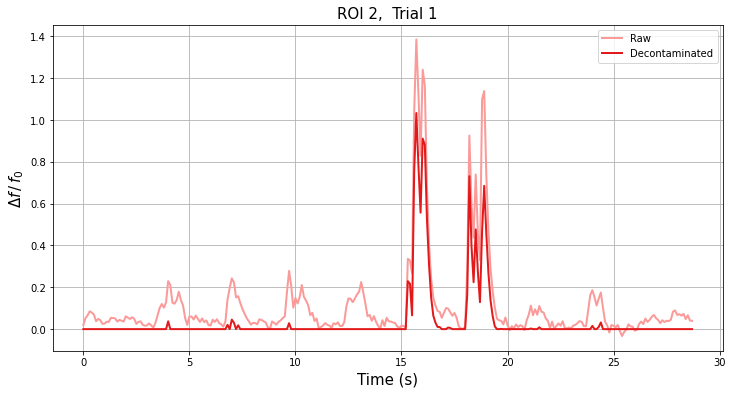

In [15]:
# Plot sample df/f0 trace

# Select the ROI and trial to plot
roi = 2
trial = 1

# Create the figure
plt.figure(figsize=(12, 6))

n_frames = experiment.deltaf_result[roi, trial].shape[1]
tt = np.arange(0, n_frames, dtype=np.float64) / sample_frequency

plt.plot(
    tt,
    experiment.deltaf_raw[roi, trial][0, :],
    lw=2,
    label="Raw",
    color=cmap((roi * 2) % cmap.N),
)
plt.plot(
    tt,
    experiment.deltaf_result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=cmap((roi * 2 + 1) % cmap.N),
)

plt.title("ROI {},  Trial {}".format(roi, trial), fontsize=15)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel(r"$\Delta f\,/\,f_0$", fontsize=15)
plt.grid()
plt.legend()
plt.show()

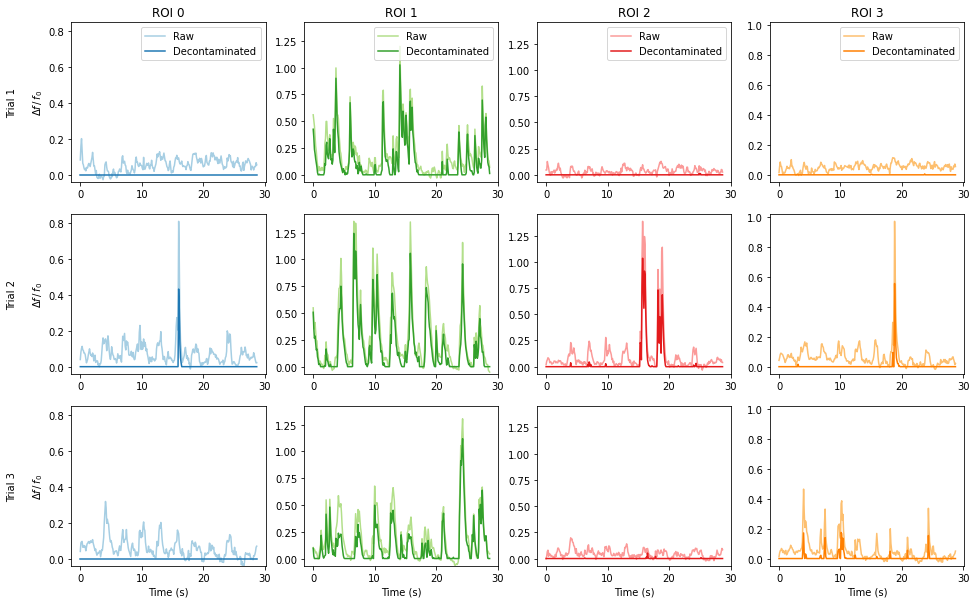

In [16]:
# Plot df/f0 for all ROIs and trials

# Find the maximum df/f0 values for each ROI
roi_max_raw = [
    np.max(
        [np.max(experiment.deltaf_raw[i_roi, i_trial][0]) for i_trial in range(n_trial)]
    )
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max(
        [
            np.max(experiment.deltaf_result[i_roi, i_trial][0])
            for i_trial in range(n_trial)
        ]
    )
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        n_frames = experiment.deltaf_result[i_roi, i_trial].shape[1]
        tt = np.arange(0, n_frames, dtype=np.float64) / sample_frequency
        plt.plot(
            tt,
            experiment.deltaf_raw[i_roi][i_trial][0, :],
            label="Raw",
            color=cmap((i_roi * 2) % cmap.N),
        )
        plt.plot(
            tt,
            experiment.deltaf_result[i_roi][i_trial][0, :],
            label="Decontaminated",
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel("Trial {}\n\n".format(i_trial + 1) + r"$\Delta f\,/\,f_0$")
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
            plt.legend()
        if i_trial == n_trial - 1:
            plt.xlabel("Time (s)")

plt.show()

The figure above shows the df/f<sub>0</sub> for the raw signal from the annotated ROI location (pale), and the result after decontaminating the signal with FISSA (dark).
For each figure, the baseline value f<sub>0</sub> is the same (taken from the raw signal).
The hues match the ROI locations and fluorescence intensity traces from above.
Each column shows the results from one of the ROI, and each row shows the results from one of the three trials.

## Exporting to MATLAB

The results can easily be exported to a MATLAB-compatible matfile as follows.

The output will appear in the `output_folder` we supplied to `experiment` when we created it.

In [17]:
experiment.to_matfile()

Loading `output_folder/separated.mat` in MATLAB will give you structs for all of FISSA's outputs.

These interface similarly as `experiment.raw`, and `experiment.result` described above, with a few small differences.

With the python interface, the outputs are 2d numpy.ndarrays each element of which is itself a 2d numpy.ndarrays.
In comparison, when the output is loaded into MATLAB this becomes a 2d cell-array each element of which is a 2d matrix.

Additionally, whilst Python indexes from 0, MATLAB indexes from 1 instead.
As a consequence of this, the results seen on Python for a given roi and trial `experiment.result[roi, trial]` correspond to the index `S.result{roi + 1, trial + 1}` on MATLAB.

Our first plot in this notebook can be replicated in MATLAB as follows:
```octave
% Load the FISSA output data
S = load('fissa-example/separated.mat')
% Select the third ROI, second trial
% On Python, this is equivalent to roi = 2; trial = 1;
roi = 3; trial = 2;
% Plot the raw and result traces for the ROI signal
figure; hold on;
plot(S.raw{roi, trial}(1, :));
plot(S.result{roi, trial}(1, :));
title(sprintf('ROI %d, Trial %d', roi, trial));
xlabel('Time (frame number)');
ylabel('Signal intensity (candela per unit area)');
legend({'Raw', 'Result'});
grid on;
box on;
set(gca,'TickDir','out');
```

Assuming all ROIs are contiguous and described by a single contour, the mean image and ROI locations can be plotted in MATLAB as follows:
```octave
% Load the FISSA output data
S = load('separated.mat')
trial = 1;
figure; hold on;
% Plot the mean image
imagesc(squeeze(S.means(trial, :, :)));
colormap('gray');
% Plot ROI locations
for i_roi = 1:size(S.result, 1);
    contour = S.roi_polys{i_roi, trial}{1};
    plot(contour(:, 2), contour(:, 1));
end
set(gca, 'YDir', 'reverse');
```

## Addendum

### Finding the TIFF files

If you find something noteworthy in one of the traces and need to backreference to the corresponding TIFF file, you can look up the path to the TIFF file with `experiment.images`.

In [18]:
trial_of_interest = 1

print(experiment.images[trial_of_interest])

exampleData/20150529/AVG_A02.tif


## FISSA customisation settings

FISSA has several user-definable settings, which can be set when defining the `fissa.Experiment` instance.

### Controlling verbosity

The level of verbosity of FISSA can be controlled with the `verbosity` parameter.

The default is `verbosity=1`.

If the verbosity parameter is higher, FISSA will print out more information while it is processing.
This can be helpful for debugging puproses.
The verbosity reaches its maximum at `verbosity=6`.

If `verbosity=0`, FISSA will run silently.

In [19]:
# Call FISSA with elevated verbosity
experiment = fissa.Experiment(images_location, rois_location, verbosity=2)
experiment.separate()

Doing region growing and data extraction for 3 trials...
  Images:
    exampleData/20150529/AVG_A01.tif
    exampleData/20150529/AVG_A02.tif
    exampleData/20150529/AVG_A03.tif
  ROI sets:
    exampleData/20150429.zip
    exampleData/20150429.zip
    exampleData/20150429.zip
  nRegions: 4
  expansion: 1


Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 0.730 seconds.
Doing signal separation for 4 ROIs over 3 trials...
  method: 'nmf'
  alpha: 0.1
  max_iter: 20000
  max_tries: 1
  tol: 0.0001


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 1.369 seconds


### Analysis parameters

The analysis performed by FISSA can be controlled with several parameters.

In [20]:
# FISSA uses multiprocessing to speed up its processing.
# By default, it will spawn one worker per CPU core on your machine.
# However, if you have a lot of cores and not much memory, you many not
# be able to suport so many workers simultaneously.
# In particular, this can be problematic during the data preparation step
# in which tiffs are loaded into memory.
# The default number of cores for the data preparation and separation steps
# can be changed as follows.
ncores_preparation = 4  # If None, uses all available cores
ncores_separation = None  # if None, uses all available cores

# By default, FISSA uses 4 subregions for the neuropil region.
# If you have very dense data with a lot of different signals per unit area,
# you may wish to increase the number of regions.
nRegions = 8

# By default, each surrounding region has the same area as the central ROI.
# i.e. expansion = 1
# However, you may wish to increase or decrease this value.
expansion = 0.75

# The degree of signal sparsity can be controlled with the alpha parameter.
alpha = 0.02

# If you change the experiment parameters, you need to change the cache directory too.
# Otherwise FISSA will try to reload the results from the previous run instead of
# computing the new results. FISSA will throw an error if you try to load data which
# was generated with different analysis parameters to its parameters.
output_folder2 = output_folder + "_alt"

# Set up a FISSA experiment with these parameters
experiment = fissa.Experiment(
    images_location,
    rois_location,
    output_folder2,
    nRegions=nRegions,
    expansion=expansion,
    alpha=alpha,
    ncores_preparation=ncores_preparation,
    ncores_separation=ncores_separation,
)

# Extract the data with these new parameters.
experiment.separate()

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 1.040 seconds.
Saving extracted traces to fissa-example_alt/prepared.npz


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 4.77 seconds
Saving results to fissa-example_alt/separated.npz


We can plot the new results for our example trace from before. Although we doubled the number of neuropil regions around the cell, very little has changed for this example because there were not many sources of contamination.

However, there will be more of a difference if your data has more neuropil sources per unit area within the image.

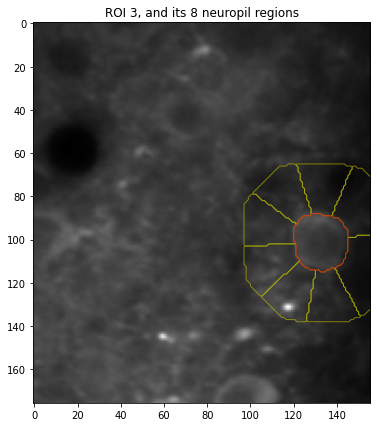

In [21]:
# Plot one ROI along with its neuropil regions

# Select which ROI and trial to plot
trial = 0
roi = 3

# Plot the mean image for the trial
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")
# Get axes limits
XLIM = plt.xlim()
YLIM = plt.ylim()

# Check the number of neuropil
n_npil = len(experiment.roi_polys[roi, trial]) - 1

# Plot all the neuropil regions in yellow
for i_npil in range(1, n_npil + 1):
    for contour in experiment.roi_polys[roi, trial][i_npil]:
        plt.fill(
            contour[:, 1],
            contour[:, 0],
            facecolor="none",
            edgecolor="y",
            alpha=0.6,
        )

# Plot the ROI outline in red
for contour in experiment.roi_polys[roi, trial][0]:
    plt.fill(
        contour[:, 1],
        contour[:, 0],
        facecolor="none",
        edgecolor="r",
        alpha=0.6,
    )

# Reset axes limits
plt.xlim(XLIM)
plt.ylim(YLIM)

plt.title("ROI {}, and its {} neuropil regions".format(roi, experiment.nRegions))
plt.show()

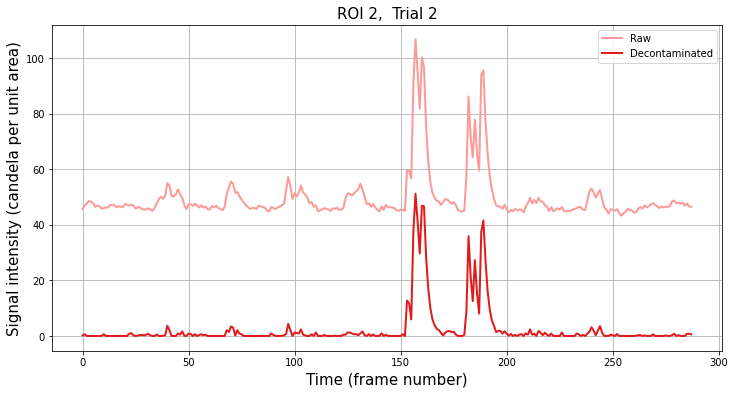

In [22]:
# Plot the new results
roi = 2
trial = 1

plt.figure(figsize=(12, 6))

plt.plot(
    experiment.raw[roi, trial][0, :], lw=2, label="Raw", color=cmap((roi * 2) % cmap.N)
)
plt.plot(
    experiment.result[roi, trial][0, :],
    lw=2,
    label="Decontaminated",
    color=cmap((roi * 2 + 1) % cmap.N),
)

plt.title("ROI {},  Trial {}".format(roi, i_trial), fontsize=15)
plt.xlabel("Time (frame number)", fontsize=15)
plt.ylabel("Signal intensity (candela per unit area)", fontsize=15)
plt.grid()
plt.legend()
plt.show()

Alternatively, these settings can be refined after creating the `experiment` object, as follows.

In [23]:
experiment.ncores_preparation = 8
experiment.alpha = 0.02
experiment.expansion = 0.75

### Loading data from large tiff files

By default, FISSA loads entire tiff files into memory at once and then manipulates all ROIs within the tiff.
This can sometimes be problematic when working with very large tiff files which can not be loaded into memory all at once.
If you have out-of-memory problems, you can activate FISSA's low memory mode, which will cause it to manipulate each tiff file frame-by-frame.

In [24]:
experiment = fissa.Experiment(
    images_location, rois_location, output_folder, lowmemory_mode=True
)
experiment.separate(redo_prep=True)

Loading data from cache fissa-example/prepared.npz
Loading data from cache fissa-example/separated.npz


Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 4 ROIs across 3 trials in 2.94 seconds.
Saving extracted traces to fissa-example/prepared.npz


Separating data:   0%|          | 0/4 [00:00<?, ?it/s]

Finished separating signals from 4 ROIs across 3 trials in 3.75 seconds
Saving results to fissa-example/separated.npz


### Handling custom formats

By default, FISSA can use tiff files or numpy arrays as its input image data, and numpy arrays or ImageJ zip files for the ROI definitions.
However, it is also possible to extend this functionality and integrate other data formats into FISSA in order to work with other custom and/or proprietary formats that might be used in your lab.

This is done by defining your own DataHandler class.
Your custom data handler should be a subclass of [fissa.extraction.DataHandlerAbstract](https://fissa.readthedocs.io/en/stable/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerAbstract), and implement the following methods:

- `image2array(image)` takes an image of whatever format and turns it into *data* (typically a numpy.ndarray).
- `getmean(data)` calculates the 2D mean for a video defined by *data*.
- `rois2masks(rois, data)` creates masks from the rois inputs, of appropriate size *data*.
- `extracttraces(data, masks)` applies the *masks* to *data* in order to extract traces.

See [fissa.extraction.DataHandlerAbstract](https://fissa.readthedocs.io/en/stable/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerAbstract) for further description for each of the methods.

If you only need to handle a new *image* input format, which is converted to a numpy.ndarray, you may find it is easier to create a subclass of the default datahandler, [fissa.extraction.DataHandlerTifffile](https://fissa.readthedocs.io/en/stable/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerTifffile).
In this case, only the `image2array` method needs to be overwritten and the other methods can be left as they are.

In [25]:
from fissa.extraction import DataHandlerTifffile

# Define a custom datahandler class.
#
# By inheriting from DataHandlerTifffile, most methods are defined
# appropriately. In this case, we only need to overwrite the
# `image2array` method to work with our custom data format.


class DataHandlerCustom(DataHandlerTifffile):
    @staticmethod
    def image2array(image):
        """Open a given image file as a custom instance.

        Parameters
        ----------
        image : custom
            Your image format (avi, hdf5, etc.)

        Returns
        -------
        numpy.ndarray
            A 3D array containing the data, shaped
            ``(frames, y_coordinate, x_coordinate)``.
        """
        # Some custom code
        pass


# Then pass an instance of this class to fissa.Experiment when creating
# a new experiment.
datahandler = DataHandlerCustom()

experiment = fissa.Experiment(
    images_location,
    rois_location,
    datahandler=datahandler,
)

For advanced users that want to entirely replace the DataHandler with their own methods, you can also inherit a class from the abstract class, [fissa.extraction.DataHandlerAbstract](https://fissa.readthedocs.io/en/stable/source/packages/fissa.extraction.html#fissa.extraction.DataHandlerAbstract).
This can be useful if you want to integrate FISSA into your workflow without changing everything into the numpy array formats that FISSA usually uses internally.